# Fe3+/Fe2+ model errors

This notebook shows the procedure we used to estimate errors on melt Fe3+/Fe2+ models. We use a validation dataset with measured melt Fe3+/Fe2+ ratios to estimate the accuracy and precision of the models included in MagmaPandas. The dataset can be downloaded [here](https://github.com/TDGerve/MagmaPandas/blob/main/src/MagmaPandas/model_calibrations/data/Fe3Fe2_calibration_data.csv)

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize as opt
from scipy.interpolate import splrep, splev
from IPython.display import clear_output

import MagmaPandas as mp
import MagmaPandas.Fe_redox.Fe3Fe2_models as fe
from MagmaPandas.tools.model_errors import _error_func, _running_stddev

import matplotlib.pyplot as plt

Read the validation dataset and remove compositions not relevant for igneous petrology.

In [4]:
slags = ["KC1989", "K2000", "HI2007"]
hydrous = ["G2002", "G2003", "Bc2005"]
simplified_compositions = ["M2006"]#"BM2010"

exclude = slags + simplified_compositions

data = pd.read_csv("../../../src/MagmaPandas/model_calibrations/data/Fe3Fe2_calibration_data.csv")
data = data.replace([np.inf, -np.inf], np.nan)
data = data.query("ref not in @exclude")

Prepare data needed to run the models

In [5]:
models = mp.Fe3Fe2_models
results = {}

melts = mp.Melt(data, units="wt. %", datatype="oxide")
melts = melts[melts.elements]
melts.recalculate(inplace=True)

T_K = data["T_K"]
P_bar = data["P_bar"]
fO2 = data["fO2"]

These are all the models we are going to test

In [6]:
print("\n".join(models))

armstrong2019
borisov2018
deng2020
fixed
hirschmann2022
jayasuriya2004
kress_carmichael1991
oneill2006
oneill2018
putirka2016_6b
putirka2016_6c
sun2024
zhang2017


Calculate Fe3Fe2 for the validation dataset with all models

In [5]:
for i, m in enumerate(models):

    model = getattr(fe, m)

    clear_output()
    print(f"model: {m}\n{i+1:03}/{len(models):03}")

    Fe3Fe2 = data[["ref", "run", "P_bar", "T_K", "fO2", "_Fe3Fe2",]].copy()
    Fe3Fe2["_Fe3Fe2_model"] = model.calculate_Fe3Fe2(melt_mol_fractions=melts.moles(), P_bar=P_bar, T_K=T_K, fO2=fO2)
    Fe3Fe2["delta"] = Fe3Fe2["_Fe3Fe2_model"] -Fe3Fe2["_Fe3Fe2"]
    Fe3Fe2 = Fe3Fe2.sort_values("_Fe3Fe2")

    results[m] = Fe3Fe2

    

model: putirka2016_6c
012/012


/Users/thomas/Dropbox/research/python/packages/MagmaPandas/src/MagmaPandas/parse_io/parse.py:61: UserWarning: Cr2O3 missing in composition and set to 0.
  w.warn(


Plot showing model accuracies

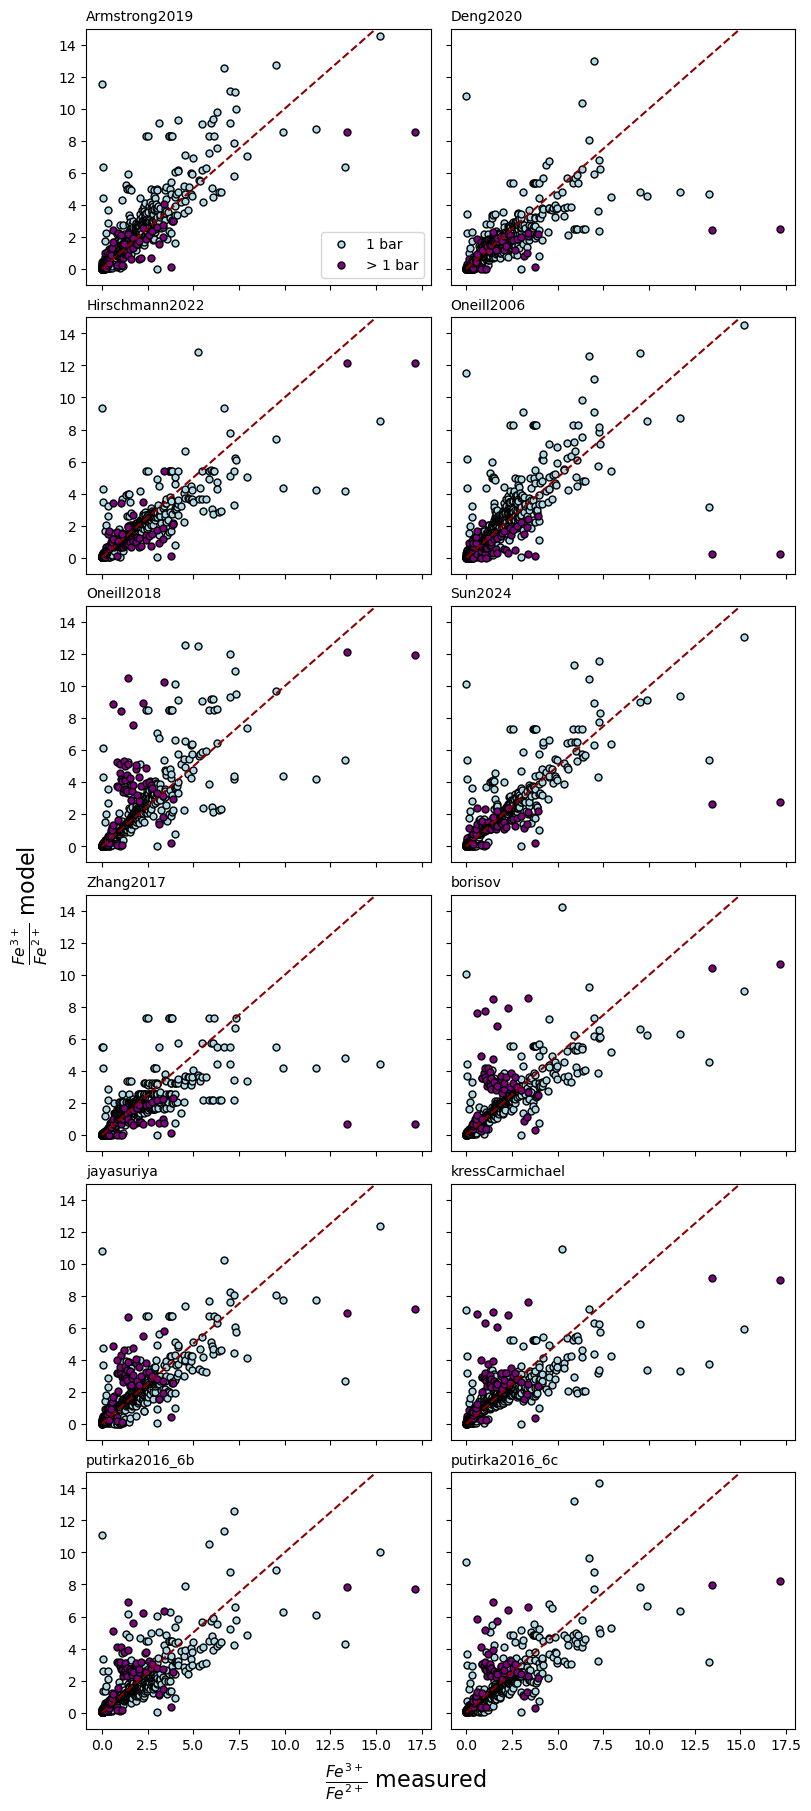

In [ ]:
qry = ""
pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(8,18), sharex=True, sharey=True, constrained_layout=True)

x_max = data["_Fe3Fe2"].max()

for i, (name, d) in enumerate(results.items()):

    d_lp = d.query("(P_bar <= @pressure_cutoff) & (_Fe3Fe2 < 20)")
    d_hp = d.query("(P_bar > @pressure_cutoff) & (_Fe3Fe2 < 20)")

    for df, c, l in zip((d_lp, d_hp), ("lightblue", "purple"), ("1 bar", "> 1 bar")):  
    
        axs[i // 2, i % 2].plot(df["_Fe3Fe2"] , df["_Fe3Fe2_model"] , "o", mec="k", markersize=5, c=c, label=l)
        
    axs[i // 2, i % 2].plot([0, 15], [0, 15], "--", c="darkred", linewidth=1.5)
    axs[i // 2, i % 2].set_title(name, loc="left", size=10)


axs[0, 0].set_ylim(-1,15)
axs[0,0].legend()


fig.supxlabel("$\\frac{Fe^{3+}}{Fe^{2+}}$ measured", size=16)
fig.supylabel("$\\frac{Fe^{3+}}{Fe^{2+}}$ predicted", size=16)
plt.show()

Alternative plot showing model accuracies

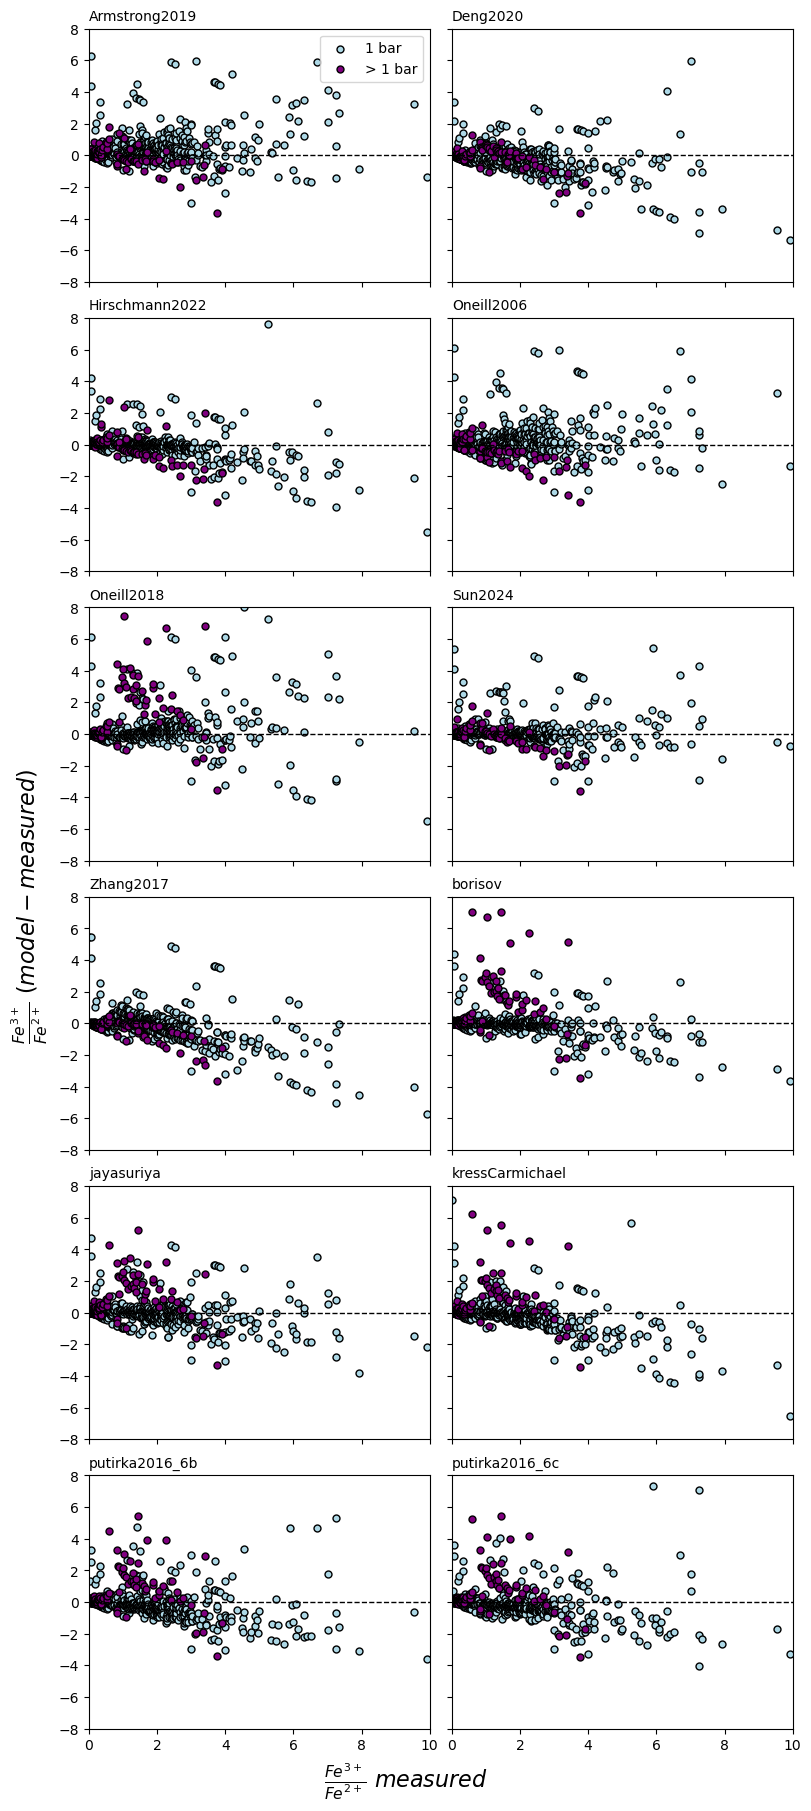

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(8,18), sharey=True, sharex=True, constrained_layout=True)

for i, (name, d) in enumerate(results.items()):
    
    d_lp = d.query("P_bar <= @pressure_cutoff")
    d_hp = d.query("P_bar > @pressure_cutoff")


    for df, c, l in zip((d_lp, d_hp), ("lightblue", "purple"), ("1 bar", "> 1 bar")):        

        axs[i // 2, i % 2].scatter(df["_Fe3Fe2"], df["delta"], marker="o", ec="k", c=c, s=5**2, label=l)

    axs[i // 2, i % 2].axhline(y=0, linestyle="--", linewidth=1., c="k")
    axs[i // 2, i % 2].set_title(name, loc="left", size=10)    


axs[0,0].set_ylim(-8, 8)
axs[0,0].set_xlim(0, 10)
axs[0,0].legend()


fig.supylabel("$\\frac{Fe^{3+}}{Fe^{2+}}\ (predicted - measured)$", size=16)
fig.supxlabel("$\\frac{Fe^{3+}}{Fe^{2+}}\ measured$", size=16)

plt.show()



Plot showing model precision for experiments conducted at 1 bar. Precision is estimated from the standard deviation calculated in a moving window of 30 samples (i.e. the running standard deviation). Red lines show standard deviations in Fe3+/Fe2+ values (left y-axis) and green lines relative standard deviations are percentages (right y-axis). Both are plotted against the measured Fe3+/Fe2+ ratio on the x-axis. Both the absolute and relative standard deviations generally increase with measure Fe3+/Fe2+ ratios. We fitted mixed exponential + polynomial curves to the absolute standard deviations. The selected shapes for these curves are purely emperical. When [MagmaPEC](https://magmapec.readthedocs.io/en/latest/index.html) is run a 1 bar, it uses these curves to calculate errors during its error propagation model.

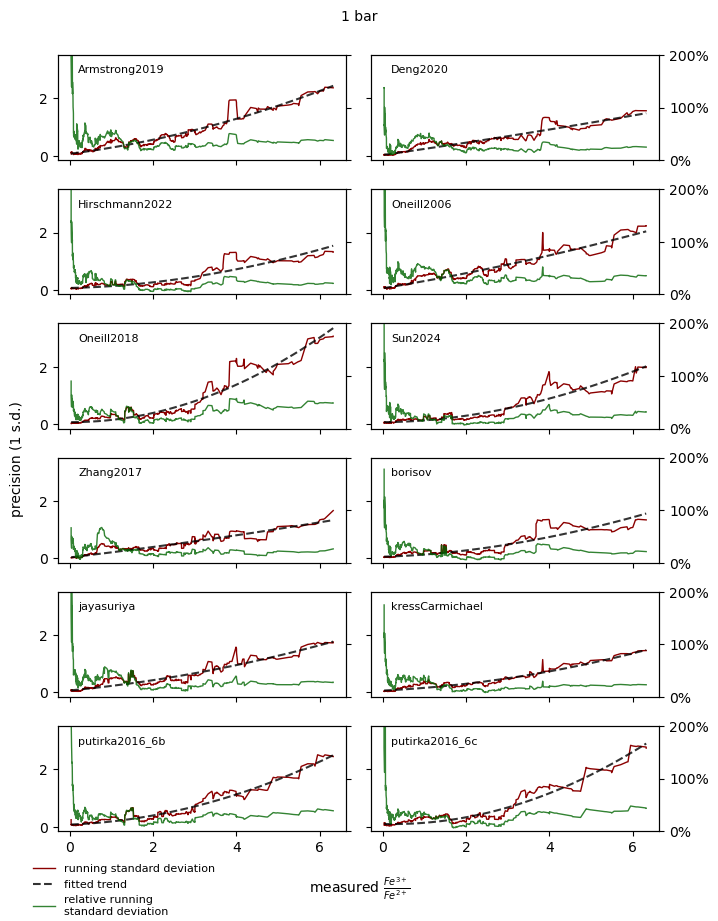

In [ ]:
error_params = {}

mm = 1 / 25.4


from matplotlib.ticker import FuncFormatter

pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(185 * mm, 230 * mm), sharey=True, sharex=True, tight_layout=True)

sec_axs = np.empty(shape=axs.shape, dtype=axs.dtype)

for i, (name, d) in enumerate(results.items()):
    
    d_lp = d.query("P_bar <= @pressure_cutoff & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")

    idx = d_lp["_Fe3Fe2_model"].dropna().index
    xvals, stddev = _running_stddev(d_lp.loc[idx, "_Fe3Fe2"], d_lp.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    error_params[name] = f_results[0]

    params = splrep(xvals, stddev, s=3)
    
    # axs[i // 2, i % 2].plot(d.query(qry)["_Fe3Fe2"] , d.query(qry)["_Fe3Fe2_model"] , "o", mec="k", markersize=3)
    axs[i // 2, i % 2].plot(xvals, stddev, "-", color="darkred", linewidth=1, label="running standard deviation")
    axs[i // 2, i % 2].plot(xvals, _error_func(xvals, *error_params[name]), "--", color="k", linewidth=1.5, alpha=0.8, label="fitted trend")
    
    # axs[i // 2, i % 2].plot(xvals, splev(xvals, params), "--", color="blue", linewidth=1.5, alpha=0.8)


    sec_axs[i // 2, i % 2] = axs[i // 2, i % 2].twinx()
    sec_axs[i // 2, i % 2].set_ylim(0,2)
    sec_axs[i // 2, i % 2].plot(xvals, stddev / xvals, "-", color="darkgreen", linewidth=1, alpha=0.8, label="relative running\nstandard deviation")

    

    axs[i // 2, i % 2].set_title(name, y=0.75, x=0.07, size=8, horizontalalignment="left")
    sec_axs[i // 2, i % 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    if (i % 2) == 0:
        sec_axs[i // 2, i % 2].set_yticklabels([])

h1, l1 = axs[0, 0].get_legend_handles_labels()
h2, l2 = sec_axs[0, 0].get_legend_handles_labels()
h = h1 + h2
l = l1 + l2
fig.legend(h, l, prop={"size": 8}, loc=(0.04, 0.0), frameon=False)

label_size = 10
fig.supxlabel("measured $\\frac{Fe^{3+}}{Fe^{2+}}$", size=label_size)
fig.supylabel("precision (1 s.d.)", size=label_size)
fig.suptitle("1 bar",va='bottom', size=label_size)

plt.show()

Store fitted mixed exponential + polynomial functions to the 1 bar running standard deviations. Coefficients are printed below

In [12]:
for i, (name, d) in enumerate(results.items()):
    
    d = d.query("P_bar <= 1 & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")
    idx = d["_Fe3Fe2_model"].dropna().index

    xvals, stddev = _running_stddev(d.loc[idx, "_Fe3Fe2"], d.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    error_params[name] = f_results[0]

    print(f"\n{name}:\n{(np.array(f_results[0]),)}")


Armstrong2019:
(array([1.85786883e-01, 3.01012716e-02, 9.80903060e-01, 1.38943588e+02]),)

Deng2020:
(array([2.07517182e-01, 3.67122574e-03, 9.81786273e-01, 1.96442938e+02]),)

Hirschmann2022:
(array([0.06558719, 0.02810096, 0.56167845, 4.64421989]),)

Oneill2006:
(array([2.40671679e-01, 1.17056951e-02, 9.86394234e-01, 2.09113418e+02]),)

Oneill2018:
(array([1.05928984e-02, 8.16688488e-02, 7.86674390e-01, 1.12117269e+01]),)

Sun2024:
(array([0.05573283, 0.04157452, 0.4727692 , 3.60686759]),)

Zhang2017:
(array([1.71420881e-01, 5.50814149e-03, 9.85221818e-01, 2.35216497e+02]),)

borisov:
(array([0.07881702, 0.02656421, 0.4333133 , 3.4452295 ]),)

jayasuriya:
(array([1.38784813e-01, 2.08193376e-02, 9.85875764e-01, 1.86942686e+02]),)

kressCarmichael:
(array([7.05463020e-02, 2.43940927e-02, 9.88024806e-01, 2.25645326e+02]),)

putirka2016_6b:
(array([5.72217982e-02, 5.16056662e-02, 9.85659083e-01, 1.81879745e+02]),)

putirka2016_6c:
(array([-3.34648539e-02,  7.56520883e-02,  9.84864214e-0

Plot showing model precision in experimentes conducted at pressures > 1 bar. The total pressure range of the included samples is 0.2 - 28 GPa Precision is estimated from the standard deviation calculated in a moving window of 30 samples (i.e. the running standard deviation). Red lines show standard deviations in Fe3+/Fe2+ values (left y-axis) and green lines relative standard deviations are percentages (right y-axis). Both are plotted against the measured Fe3+/Fe2+ ratio on the x-axis. For most models, standard deviations do not show systematic trends with measured Fe3+/Fe2+ ratios. Instead, standard deviations trends are often curved and decrease after an initial increase. This is especially apparant in the models that have been calibrated exclusively at 1 bar ({cite:t}`borisov_ferricferrous_2018`,{cite:t}`kress_compressibility_1991`, {cite:t}`Jayasuriya2004`, {cite:t}`Putirka2016` and {cite:t}`oneill_oxidation_2018`), and shows that they do not capture Fe3+/Fe2+ variations with pressure.



We fitted splines to the absolute standard deviations. When [MagmaPEC](https://magmapec.readthedocs.io/en/latest/index.html) is run at pressures > 1 bar, it uses these fitted curves to calculate errors during its error propagation model.

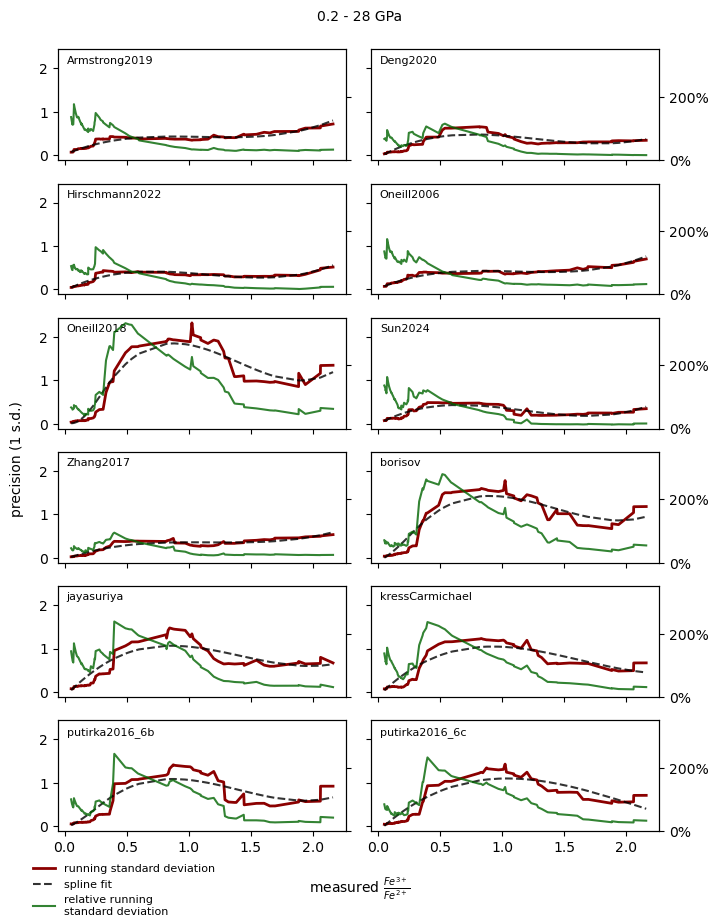

In [ ]:
error_params = {}


from matplotlib.ticker import FuncFormatter

pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(185 * mm, 230 * mm), sharey=True, sharex=True, tight_layout=True)

sec_axs = np.empty(shape=axs.shape, dtype=axs.dtype)

for i, (name, d) in enumerate(results.items()):
    
    d_hp = d.query("P_bar > @pressure_cutoff").sort_values("_Fe3Fe2")

    idx = d_hp["_Fe3Fe2_model"].dropna().index
    
    xvals, stddev = _running_stddev(d_hp.loc[idx, "_Fe3Fe2"], d_hp.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    weights = np.ones(len(xvals))
    weights[0]=10
    params = splrep(xvals, stddev, w=weights, s=3)
    # f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    # error_params[name] = f_results[0]
    
    # axs[i // 2, i % 2].plot(d.query(qry)["_Fe3Fe2"] , d.query(qry)["_Fe3Fe2_model"] , "o", mec="k", markersize=3)
    axs[i // 2, i % 2].plot(xvals, stddev, "-", color="darkred", linewidth=2, label="running standard deviation")
    axs[i // 2, i % 2].plot(xvals, splev(xvals, params), "--", color="k", linewidth=1.5, alpha=0.8, label="spline fit")

    sec_axs[i // 2, i % 2] = axs[i // 2, i % 2].twinx()
    sec_axs[i // 2, i % 2].set_ylim(0,3.5)
    sec_axs[i // 2, i % 2].plot(xvals, stddev / xvals, "-", color="darkgreen", linewidth=1.5, alpha=0.8, label="relative running\nstandard deviation")

    axs[i // 2, i % 2].set_title(name, y=0.8, x=0.03, size=8, horizontalalignment="left")
    sec_axs[i // 2, i % 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    if (i % 2) == 0:
        sec_axs[i // 2, i % 2].set_yticklabels([])
    

h1, l1 = axs[0, 0].get_legend_handles_labels()
h2, l2 = sec_axs[0, 0].get_legend_handles_labels()
h = h1 + h2
l = l1 + l2
fig.legend(h, l, prop={"size": 8}, loc=(0.04, 0.0), frameon=False)

label_size = 10
fig.supxlabel("measured $\\frac{Fe^{3+}}{Fe^{2+}}$", size=label_size)
fig.supylabel("precision (1 s.d.)", size=label_size)
fig.suptitle("0.2 - 28 GPa",va='bottom', size=label_size)

plt.show()

Store and print fited spline parameters

In [17]:
for i, (name, d) in enumerate(results.items()):
    
    d = d.query("P_bar > 1 & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")
    idx = d["_Fe3Fe2_model"].dropna().index

    xvals, stddev = _running_stddev(d.loc[idx, "_Fe3Fe2"], d.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    weights = np.ones(len(xvals))
    weights[0]=10

    print(f"\n{name}:\n{splrep(xvals, stddev, w=weights,s=3)}")


Armstrong2019:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([ 0.0749464 ,  0.85863398, -0.02280428,  0.80182304,  0.        ,
        0.        ,  0.        ,  0.        ]), 3)

Deng2020:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([ 0.02155258,  1.06271701, -0.05844322,  0.37584427,  0.        ,
        0.        ,  0.        ,  0.        ]), 3)

Hirschmann2022:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([ 0.04317791,  0.97216147, -0.23208595,  0.55753749,  0.        ,
        0.        ,  0.        ,  0.        ]), 3)

Oneill2006:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([ 0.07453568,  0.86373442, -0.03963105,  0.76323943,  0.        ,
        0.        ,  0.        ,  0.        ]), 3)